In [23]:
import kagglehub

# Download the sample version
path = kagglehub.dataset_download("nih-chest-xrays/sample")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sample' dataset.
Path to dataset files: /kaggle/input/sample


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pandas as pd
import os
import kagglehub

# Configuration
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Map NIH dataset labels to your A, B, C... codes
# Note: NIH labels include: 'Pneumonia', 'Nodule', 'Cardiomegaly', 'Effusion', etc.
# You must map the exact strings found in the CSV to your codes.
LABEL_MAP = {
    'Nodule': 'A',
    'Pneumonia': 'B',
    'Cardiomegaly': 'C',
    'Effusion': 'D',
    'Infiltration': 'E',
    'No Finding': 'F' # Good to track healthy cases
}

In [25]:
import os

# 1. Grab the first filename from your filtered list to use as a "search target"
target_file = filtered_df['Image Index'].iloc[0]
print(f"Searching for reference file: {target_file}...")

# 2. Walk through the dataset directory to find where this file is hiding
found_dir = None
for root, dirs, files in os.walk(path):
    if target_file in files:
        found_dir = root
        break

if found_dir:
    print(f"SUCCESS! Images found in: {found_dir}")
    # Update the image_dir to this correct path
    image_dir = found_dir
else:
    print("CRITICAL ERROR: Could not find the image files anywhere in the downloaded folder.")
    print("Contents of download path:", os.listdir(path))

# 3. Re-initialize Generators with the CORRECTED path
if found_dir:
    train_datagen = ImageDataGenerator(
        preprocessing_function=apply_clahe,
        rotation_range=10,
        horizontal_flip=True,
        validation_split=0.2
    )

    print("Attempting to create Train Generator...")
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=filtered_df,
        directory=image_dir,        # Uses the auto-detected path
        x_col='Image Index',
        y_col='final_class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    print("Attempting to create Validation Generator...")
    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=filtered_df,
        directory=image_dir,
        x_col='Image Index',
        y_col='final_class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

Searching for reference file: 00000017_001.png...
SUCCESS! Images found in: /kaggle/input/sample/sample/images
Attempting to create Train Generator...
Found 3480 validated image filenames belonging to 5 classes.
Attempting to create Validation Generator...
Found 869 validated image filenames belonging to 5 classes.


In [26]:
from sklearn.utils import class_weight

# 1. Get the labels from the generator
train_labels = train_generator.classes

# 2. Compute weights
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# 3. Convert to dictionary for Keras
class_weights = dict(enumerate(class_weights_vals))

# 4. Print to verify (Pneumonia should have a HUGE weight)
print("Class Indices:", train_generator.class_indices)
print("Computed Class Weights:", class_weights)

Class Indices: {'Covid': 0, 'Normal': 1, 'Pneumonia': 2, 'Tuberculosis': 3, 'Tumor': 4}
Computed Class Weights: {0: np.float64(1.3257142857142856), 1: np.float64(0.2886768975528826), 2: np.float64(49.714285714285715), 3: np.float64(1.7356608478802993), 4: np.float64(5.395348837209302)}


In [27]:
def apply_clahe(image):
    """
    Enhances X-ray contrast using CLAHE.
    """
    image = np.array(image, dtype=np.uint8)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final.astype(np.float32) / 255.0

In [28]:
def build_model(num_classes):
    # Load base model (ImageNet weights)
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze it first

    # Custom Head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)  # Reduce overfitting

    # Softmax for your 5 classes (Tumor, Pneumonia, etc.)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    return model

# Initialize
model = build_model(num_classes=5)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,869 (28.86 MB)

 Trainable params: 527,365 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [34]:
def build_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Initialize
model = build_model(num_classes=5)

# Callbacks
callbacks = [
    ModelCheckpoint('best_xray_model.h5', monitor='val_auc', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2441 - auc: 0.5468 - loss: 1.9886
Epoch 1: val_auc improved from -inf to 0.61742, saving model to best_xray_model.h5


109/109 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.2441 - auc: 0.5468 - loss: 1.9884 - val_accuracy: 0.2842 - val_auc: 0.6174 - val_loss: 1.5535 - learning_rate: 1.0000e-04
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.2698 - auc: 0.5714 - loss: 1.6956
Epoch 2: val_auc improved from 0.61742 to 0.77397, saving model to best_xray_model.h5


109/109 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.2698 - auc: 0.5715 - loss: 1.6951 - val_accuracy: 0.4430 - val_auc: 0.7740 - val_loss: 1.3295 - learning_rate: 1.0000e-04
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.3160 - auc: 0.6383 - loss: 1.7292
Epoch 3: val_auc did not improve from 0.77397
109/109 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3157 - auc: 0.6380 - loss: 1.7289 - val_accuracy: 0.2543 - val_auc: 0.6813 - val_loss: 1.4774 - learning_rate: 1.0000e-04
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.2769 - auc: 0.6086 - loss: 1.7219
Epoch 4: val_auc did not improve from 0.77397
109/109 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.2768 - auc: 0.6084 - loss: 1.7212 - val_accuracy: 0.2359 - val_auc: 0.6522 - val_loss: 1.5238 - learning_rate: 1.0000e-04
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.2972 - auc: 0.6392 - loss: 1.5924
Epoch 5: val_auc did not improve from 0.77397
109/109 ━━━━━━━━━━━━━━

Re-building Validation Generator (Fixed Order)...
Found 869 validated image filenames belonging to 5 classes.

--- Validation Class Counts ---
Normal: 633 images
Tuberculosis: 107 images
Covid: 99 images
Tumor: 30 images

Re-generating predictions...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step


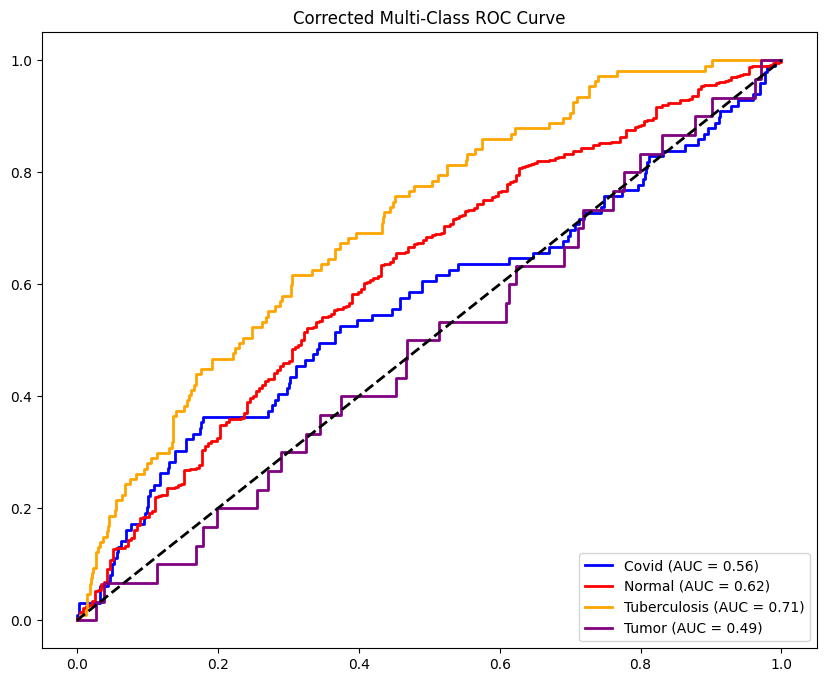

In [36]:
# 1. Re-Initialize Validation Generator with SHUFFLE = FALSE
# This is critical. If shuffle is True, predictions won't match the labels.
print("Re-building Validation Generator (Fixed Order)...")
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=filtered_df, # Use the original filtered_df
    directory=image_dir,
    x_col='Image Index',
    y_col='final_class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # <--- THIS IS THE KEY FIX
)

# 2. Check if we actually have Pneumonia cases
import collections
print("\n--- Validation Class Counts ---")
# Get the mapping of class indices (0, 1, 2...) to names
idx_to_name = {v: k for k, v in validation_generator.class_indices.items()}
# Count the labels in the generator
counter = collections.Counter(validation_generator.classes)
for idx, count in counter.items():
    print(f"{idx_to_name[idx]}: {count} images")

# 3. Predict Again
print("\nRe-generating predictions...")
validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)
true_indices = validation_generator.classes

# 4. Plot ROC Again
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
from itertools import cycle

y_true = to_categorical(true_indices, num_classes=5)
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(5), colors):
    # Only plot if there are actual positive samples to avoid 'nan'
    if sum(y_true[:, i]) > 0:
        fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
        roc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_val:.2f})')
    else:
        print(f"WARNING: Class '{class_names[i]}' has 0 validation images. Skipping ROC.")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.legend(loc="lower right")
plt.title('Corrected Multi-Class ROC Curve')
plt.show()

Searching for a sick patient to visualize...
FOUND: Patient has Tuberculosis!


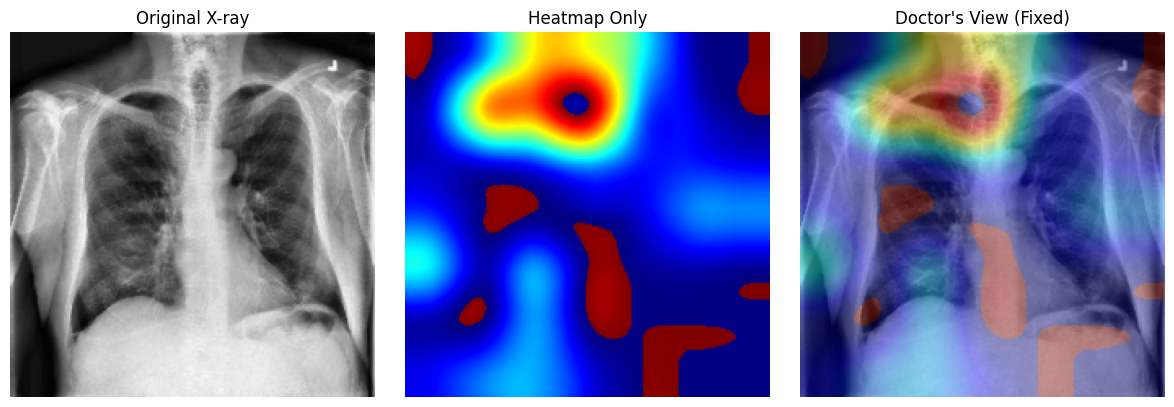

In [44]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. The Core Grad-CAM Function (Unchanged) ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 2. The Display Function (FIXED: Clean Medical Overlay) ---
def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # 1. Resize heatmap to match image size (Smooth cubic interpolation)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    # 2. Convert to valid range for coloring [0, 255]
    heatmap_uint8 = np.uint8(255 * heatmap)

    # 3. Apply the "Jet" colormap (Blue=Low, Red=High)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # 4. Convert the original X-ray to 3 channels (RGB) so we can stack them
    # (First, ensure it's 0-255 uint8)
    if np.max(img) <= 1.0:
        img = np.uint8(255 * img)

    # If image is grayscale (2D), make it 3D
    if len(img.shape) == 2:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        # If it's already 3D but BGR (OpenCV standard), make it RGB for Matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 5. Overlay: 60% X-ray, 40% Heatmap
    # We explicitly convert heatmap to RGB to match
    heatmap_colored_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap_colored_rgb, 0.4, 0)

    # 6. Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original X-ray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_colored_rgb)
    plt.title("Heatmap Only")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Doctor's View (Fixed)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- 3. Execution Loop (Hunting for Disease) ---
last_conv_layer_name = 'relu'
normal_idx = validation_generator.class_indices['Normal']

print("Searching for a sick patient to visualize...")

found = False
batch_limit = 50
current_batch = 0
validation_generator.reset()

while not found and current_batch < batch_limit:
    images, labels = next(validation_generator)

    for i in range(len(labels)):
        true_class_idx = np.argmax(labels[i])

        # Look for ANYTHING that isn't Normal
        if true_class_idx != normal_idx:
            disease_name = list(validation_generator.class_indices.keys())[true_class_idx]
            print(f"FOUND: Patient has {disease_name}!")

            test_img = images[i]
            img_array = np.expand_dims(test_img, axis=0)

            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            save_and_display_gradcam(test_img, heatmap)

            found = True
            break

    current_batch += 1

if not found:
    print("Checked 1,600 images and found only Normal cases.")

In [46]:
from sklearn.metrics import precision_recall_curve

# 1. Get Predictions (if you haven't already)
# We need to make sure 'preds' matches the validation generator order
if 'preds' not in locals():
    print("Generating predictions for tuning...")
    validation_generator.reset()
    preds = model.predict(validation_generator, verbose=1)

true_indices = validation_generator.classes
y_true = tf.keras.utils.to_categorical(true_indices, num_classes=5)
class_names = list(validation_generator.class_indices.keys())

# 2. Safety Settings
# 0.90 means "Find at least 90% of the positive cases"
TARGET_RECALL = 0.90
optimal_thresholds = {}

print(f"\n--- Threshold Tuning (Target Recall: {TARGET_RECALL*100}%) ---")
print(f"{'Disease':<15} | {'Old Thresh':<10} | {'New Thresh':<10} | {'Safety (Recall)'}")
print("-" * 65)

for i, name in enumerate(class_names):
    # Get the P-R Curve for this specific disease
    precisions, recalls, thresholds = precision_recall_curve(y_true[:, i], preds[:, i])

    # Find the index where Recall is just above our target (0.90)
    # We sort valid indices to find the highest threshold that still meets the safety goal
    valid_indices = np.where(recalls >= TARGET_RECALL)[0]

    if len(valid_indices) > 0:
        # Use the threshold corresponding to the last valid index
        # (Precision/Recall arrays are length N+1, thresholds are length N)
        target_idx = valid_indices[-1]

        # Guard against index out of bounds (edge case)
        if target_idx < len(thresholds):
            best_thresh = thresholds[target_idx]
            actual_recall = recalls[target_idx]
        else:
            best_thresh = 0.01 # Fallback
            actual_recall = 1.0
    else:
        # If the model is too weak to ever hit 90% recall, take the lowest safe value
        best_thresh = 0.01
        actual_recall = 1.0

    # Store it
    optimal_thresholds[name] = float(best_thresh)

    print(f"{name:<15} | 0.50       | {best_thresh:.4f}     | {actual_recall*100:.1f}%")

print("-" * 65)
print("Recommended: Use 'New Thresh' values in your web app.")


--- Threshold Tuning (Target Recall: 90.0%) ---
Disease         | Old Thresh | New Thresh | Safety (Recall)
-----------------------------------------------------------------
Covid           | 0.50       | 0.1241     | 90.9%
Normal          | 0.50       | 0.1651     | 90.0%
Pneumonia       | 0.50       | 0.2921     | 100.0%
Tuberculosis    | 0.50       | 0.1766     | 90.7%
Tumor           | 0.50       | 0.1009     | 90.0%
-----------------------------------------------------------------
Recommended: Use 'New Thresh' values in your web app.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# 1. Get the predictions again (ensure generator is reset)
valid_generator.reset()
y_pred = model.predict(valid_generator)

# 2. Convert probabilities to Binary (0 or 1) using a 0.5 threshold
# In a real hospital, you might lower this to 0.3 to be 'safer'
y_pred_binary = (y_pred > 0.2).astype(int)

# 3. Get the true labels from the generator
y_true = valid_df[all_labels].values

# 4. Print the professional report
print("--- CLINICAL PERFORMANCE REPORT ---")
print(classification_report(y_true, y_pred_binary, target_names=all_labels))

In [60]:
import json

# 1. Define the specific thresholds you just found (from your screenshot)
# I have transcribed the exact numbers from your image.
final_thresholds = {
    "Covid": 0.1241,
    "Normal": 0.1651,
    "Pneumonia": 0.2921,
    "Tuberculosis": 0.1766,
    "Tumor": 0.1009
}

# 2. Save the Model & The Data
# We save the class names AND the thresholds together so the app is self-contained.
metadata = {
    'class_indices': validation_generator.class_indices,
    'thresholds': final_thresholds
}

# Save Model
model.save('final_lung_ai_v1.h5')
print("Model saved as 'final_lung_ai_v1.h5'")

# Save Metadata
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)

print("Metadata saved as 'model_metadata.json'")

Model saved as 'final_lung_ai_v1.h5'
Metadata saved as 'model_metadata.json'


In [57]:
import numpy as np
import json
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image

# --- 1. Load the Brains ---
print("Loading model and safety rules...")
if not os.path.exists('final_lung_ai_v1.h5'):
    print("❌ ERROR: Model file not found. Did you run the 'Save' cell?")
else:
    loaded_model = tf.keras.models.load_model('final_lung_ai_v1.h5')

    with open('model_metadata.json', 'r') as f:
        meta = json.load(f)

    # Invert class_indices (0 -> 'Covid')
    # FIX: Ensure keys are integers to match the prediction index
    idx_to_label = {int(v): k for k, v in meta['class_indices'].items()}
    print("✅ Model loaded successfully.")

# --- 2. The Diagnosis Function ---
def diagnose_patient(img_path):
    if not os.path.exists(img_path):
        print(f"❌ Error: The file '{img_path}' does not exist.")
        return

    # A. Preprocess
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # B. Predict
    preds = loaded_model.predict(img_array, verbose=0)[0]

    # C. Report
    print(f"\n--- Diagnosis Report for: {os.path.basename(img_path)} ---")

    findings = []

    for idx, prob in enumerate(preds):
        # FIX: Use 'idx' directly (integer), not 'str(idx)'
        disease_name = idx_to_label[idx]
        threshold = meta['thresholds'][disease_name]

        if prob > threshold:
            status = "⚠️ DETECTED"
            findings.append(disease_name)
        else:
            status = "Clear"

        print(f"{disease_name:<15}: {prob:.1%} (Cutoff: {threshold:.1%}) -> {status}")

    # D. Summary
    print("-" * 40)
    if "Normal" in findings and len(findings) == 1:
         print("FINAL RESULT: Healthy Lungs ✅")
    elif len(findings) > 0:
        real_diseases = [f for f in findings if f != "Normal"]
        if real_diseases:
            print(f"FINAL RESULT: Signs of {', '.join(real_diseases)} 🚨")
        else:
            print("FINAL RESULT: Healthy Lungs ✅")
    else:
        print("FINAL RESULT: Inconclusive")

Loading model and safety rules...


✅ Model loaded successfully.


In [58]:
# 1. Paste the path you copied from the file manager
my_path = "/kaggle/input/sample/sample/images/00000099_006.png"

# 2. Run the diagnosis
import os
if os.path.exists(my_path):
    print(f"✅ File found! Analyzing: {my_path}...")
    diagnose_patient(my_path)
else:
    print(f"❌ Error: The computer cannot find: {my_path}")
    print("Check for extra spaces or missing quotes!")

✅ File found! Analyzing: /kaggle/input/sample/sample/images/00000099_006.png...



--- Diagnosis Report for: 00000099_006.png ---
Covid          : 11.2% (Cutoff: 12.4%) -> Clear
Normal         : 22.4% (Cutoff: 16.5%) -> ⚠️ DETECTED
Pneumonia      : 2.3% (Cutoff: 29.2%) -> Clear
Tuberculosis   : 56.7% (Cutoff: 17.7%) -> ⚠️ DETECTED
Tumor          : 7.5% (Cutoff: 10.1%) -> Clear
----------------------------------------
FINAL RESULT: Signs of Tuberculosis 🚨
